## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out]) 
    
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
WAIT_TIMES = [10, 25]

In [12]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping
def build_cb(waittingtimes):
    earlystop = EarlyStopping(monitor = 'val_acc', 
                          patience = waittingtimes,
                          verbose = 1)
    return earlystop

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for i, wt in enumerate(WAIT_TIMES):
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    cb = build_cb(wt)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[cb]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]    

    exp_tag = 'exp_wt_' + str(wt)
    results[exp_tag] = {
        'train-loss': train_loss,
        'val-loss': valid_loss,
        'train-acc': train_acc,
        'val-acc': valid_acc
    }

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 21s 418us/step - loss: 2.2171 - acc: 0.2750 - val_loss: 2.1472 - val_acc: 0.3045
Epoch 2/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.7527 - acc: 0.3905 - val_loss: 1.8476 - val_acc: 0.3726
Epoch 3/50
50000/50000 [==============================] - 6s 116us/step - loss: 1.6223 - acc: 0.4320 - val_loss: 1.6858 - val_acc: 0.4091
Epoch 4/50
50000/50000 [==============================] - 6s 113us/step - loss: 1.5452 - acc: 0.4593 - val_loss: 1.6304 - val_acc: 0.4304
Epoch 5/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.4932 - acc: 0.4802 - val_loss: 1.6029 - val_acc: 0.4387
Epoch 6/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.4464 - acc: 0.4965 - val_loss: 1.5652 - val_acc: 0.4439
Epoch 7/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.4069 - acc: 0.5103 - val_loss: 1.5552 -

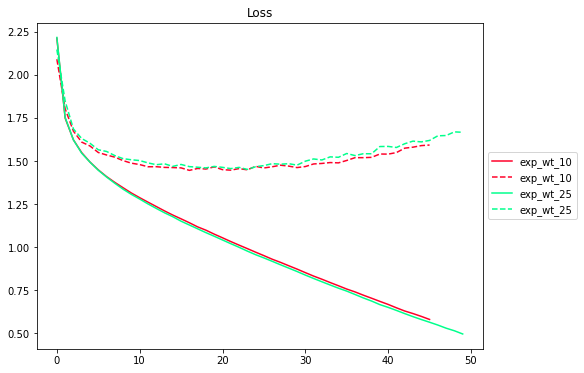

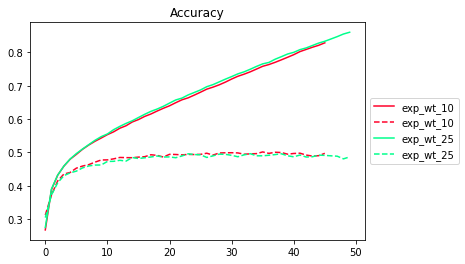

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_num = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_map = [cm(1.*i/color_num) for i in range(color_num)]

plt.figure(figsize = (8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], '-', label = cond, color = color_map[i])
    plt.plot(range(len(results[cond]['val-loss'])), results[cond]['val-loss'], '--', label = cond, color = color_map[i])
plt.title('Loss')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()

for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], '-', label = cond, color = color_map[i])
    plt.plot(range(len(results[cond]['val-acc'])), results[cond]['val-acc'], '--', label = cond, color = color_map[i])
plt.title('Accuracy')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.show()